In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D,  SpatialDropout1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn import metrics
from sklearn.model_selection import KFold
from functools import reduce

import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

Using TensorFlow backend.


In [2]:
# load data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
test_labels = pd.read_csv('./data/test_labels.csv')

test = pd.merge(test, test_labels)

test = test.drop(test.columns[0], axis=1)
test = test[test['toxic']!=-1]
# using all data for visualization
all_data = pd.concat([train, test])

# using fast text embeding
embedding_file = './data/crawl-300d-2M.vec'

all_data.head()

/Users/mayuanchao/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,Explanation\nWhy the edits made under my usern...,0000997932d777bf,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,000103f0d9cfb60f,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",000113f07ec002fd,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0001b41b1c6bb37e,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0001d958c54c6e35,0,0,0,0,0,0


Total comments  223549
Total clean comments  208457
Total tags  identity_hate     2117
insult           11304
obscene          12140
severe_toxic      1962
threat             689
dtype: int64


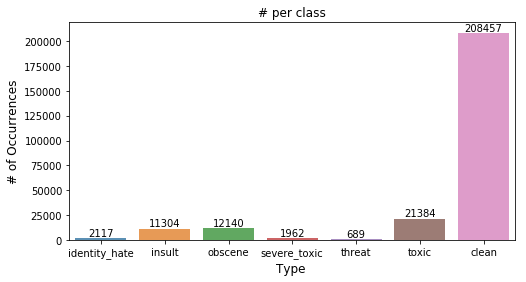

In [3]:
# Data visualizations
# Total clean comments

# marking comments without any tags as "clean".
rowsums = all_data.iloc[:,2:7].sum(axis=1)
all_data['clean'] = np.logical_not(rowsums).astype('int')

x = all_data.iloc[:,2:].sum()

# count number of clean entries
print("Total comments ", len(all_data))
print("Total clean comments ", all_data['clean'].sum())
print("Total tags ", all_data.iloc[:,2:7].sum())

# plot a graph of all the tags
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = x.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [4]:
# Word count in each comment:
all_data['count_word'] = all_data["comment_text"].apply(lambda x: len(str(x).split()))

# Unique word count
all_data['count_unique_word'] = all_data["comment_text"].apply(lambda x: len(set(str(x).split())))

# percentage of unique words
all_data['word_unique_percent'] = all_data['count_unique_word']*100/all_data['count_word']

In [5]:
# split data by class
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
y_test = test[list_classes].values

list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [6]:
# clean data
special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

def text_to_words(text):
    # remove special characters
    text=special_character_removal.sub('',text)
    
    # Replace Numbers with character 'n' 
    text=replace_numbers.sub('n', text)

    # Convert words to lower case and split them
    text = text.lower().split()
    
    # remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)

    # shorten words to their stems
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
        
    return stemmed_words

comments = []
for text in list_sentences_train:
    comments.append(text_to_words(text))
    
test_comments=[]
for text in list_sentences_test:
    test_comments.append(text_to_words(text))

In [7]:
# tokenize strings to vectors by replacing words with numbers
# Set max no of words to keep as 20000.
max_features = 20000
maxlen = 100
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(comments + test_comments))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

# pad the data to vectors of equal length by padding short sentences and trimming long sentences
def pad_data(input):
    comments_sequence = tokenizer.texts_to_sequences(input)
    return pad_sequences(comments_sequence, maxlen=maxlen)

X_t = pad_data(comments)
X_te = pad_data(test_comments)

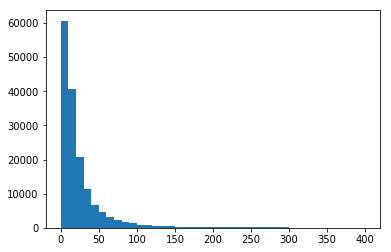

In [8]:
# visualize word distribution
totalNumWords = [len(c) for c in list_tokenized_train]
plt.hist(totalNumWords, bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [9]:
# embedding
# fast text
embed_size =300

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file, encoding="utf8"))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [10]:
# Define keras input layer
input = Input(shape=(maxlen, )) # maxlen = 100 as defined earlier

def get_model(lstm_size, cnn_size, cnn_stride, dropout):
    # embedding layer
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(input)
    x = SpatialDropout1D(dropout)(x)
    
    # bidirectional lstm layer
    x = Bidirectional(LSTM(lstm_size, return_sequences=True,name='lstm_layer'))(x)
    
    # output of lstm is feeded to a cnn network
    x = Conv1D(cnn_size, kernel_size = cnn_stride, padding = "valid", kernel_initializer = "he_uniform")(x)

    # pooling & dropout
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    x = Dropout(dropout)(x)

    # sigmoid for classification
    x = Dense(6, activation="sigmoid")(x)

    # create model
    model = Model(inputs=input, outputs=x)
    
    # compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()
    
    return model

In [ ]:
batch_size = 1780
epochs = 2
kfold = KFold(n_splits= 10, shuffle=True)
lstm = [30, 60, 90, 120]
cnn = [30, 30, 60, 60]
cnn_stride = [2, 3, 2, 3]
dropout = [0.1, 0.2, 0.2, 0.3]
history_dfs = []
for i in range(4):
    histories = []
    model = get_model(lstm[i], cnn[i], cnn_stride[i], dropout[i])
    for train, test in kfold.split(X_t):
        history = model.fit(X_t[train], y[train], batch_size=batch_size, epochs=epochs, validation_split=0.2)
        histories.append(history)
    history_data = [h.history for h in histories]
    for h in history_data:
        for key, value in h.items():
            h[key] = reduce(lambda x, y: (x + y) / 2, value)
    history_df = pd.DataFrame(history_data)
    history_dfs.append(history_df)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidi

In [ ]:
history_dfs

In [ ]:
for i in range(len(history_dfs)):
    fig = plt.figure(i)
    title = "lstm cells " + str(lstm[i]) + " | cnn filters " + str(cnn[i]) + " | cnn strides " + str(cnn_stride[i]) + " | dropout " + str(dropout[i]) + ""
    plt.title(title)
    plt.xlabel('Folds')
    sns.lineplot(data=history_dfs[1])

In [ ]:
for i in range(len(history_dfs)):
    title = "lstm cells " + str(lstm[i]) + " | cnn filters " + str(cnn[i]) + " | cnn strides " + str(cnn_stride[i]) + " | dropout " + str(dropout[i]) + ""
    print(title)
    mean_validation_loss = np.mean(history_dfs[i].val_loss.values)
    variance_validation_loss = np.var(history_dfs[i].val_loss.values)

    mean_validation_accuracy = np.mean(history_dfs[i].val_acc.values)
    variance_validation_accuracy = np.var(history_dfs[i].val_acc.values)

    print("Mean of validation loss :", mean_validation_loss)
    print("Variance of validation loss :", variance_validation_loss)
    print("Mean of validation accuracy :", mean_validation_accuracy)
    print("Variance of validation accuracy :", variance_validation_accuracy)

In [ ]:
mean_validation_loss = np.mean(history_df.val_loss.values)
variance_validation_loss = np.var(history_df.val_loss.values)

mean_validation_accuracy = np.mean(history_df.val_acc.values)
variance_validation_accuracy = np.var(history_df.val_acc.values)

print("Mean of validation loss :", mean_validation_loss)
print("Variance of validation loss :", variance_validation_loss)
print("Mean of validation accuracy :", mean_validation_accuracy)
print("Variance of validation accuracy :", variance_validation_accuracy)

In [ ]:
# test model
batch_size = 1760
epochs = 2
predictions = model.predict(X_te, batch_size=batch_size, verbose=1)

In [ ]:
# load lables
#test_labels = pd.read_csv('../data/test_labels.csv')
#test_labels = test_labels.drop(test_labels.columns[0], axis=1)
#y_test = test_labels[list_classes].values


In [ ]:
# using all data for visualization
for l in range(len(list_classes)):
    print("\n" + list_classes[l])
    print("roc auc score ", metrics.roc_auc_score(y_test[:,l], predictions[:,l]))
    print("accuracy ", metrics.accuracy_score(y_test[:,l], np.round(predictions[:,l]).astype(np.int)))
    print("precision score ", metrics.precision_score(y_test[:,l], np.round(predictions[:,l]).astype(np.int),  average='weighted'))
    print("recall score ", metrics.recall_score(y_test[:,l], np.round(predictions[:,l]).astype(np.int),  average='weighted'))
    print("f1 score ", metrics.f1_score(y_test[:,l], np.round(predictions[:,l]).astype(np.int), average='weighted'))

print("\n" + "Overall")
#print("roc auc score ", metrics.roc_auc_score(y_test, predictions))
print("accuracy ", metrics.accuracy_score(y_test, np.round(predictions).astype(np.int)))
print("precision score ", metrics.precision_score(y_test, np.round(predictions).astype(np.int),  average='weighted'))
print("recall score ", metrics.recall_score(y_test, np.round(predictions).astype(np.int),  average='weighted'))
print("f1 score ", metrics.f1_score(y_test, np.round(predictions).astype(np.int), average='weighted'))

In [ ]:
y_true = np.array([0, 0, 1, -1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
metrics.roc_auc_score(y_true, y_scores)
